> __Purpose:__ Show how the attack model improves as we let the adversary access later decoders.  E.g., if we use an earlier decoder, does it perform worse than a later decoder (one that has had more time to adapt and personalize)? 

- 14 Subjects, therefore random guessing would be 7.14% correct on average

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data and Set Params

In [5]:
# Params
# Set the number of k-folds
cv = 5
# Changed to 5 from 10 because the smallest class in cross val only has 7 instances
# NOTE: I also changed the default cv number in my function to be 5 because of this

num_conds = 8

my_metrics_cols = ['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [6]:
update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

dec_flattened_df1 = pd.read_csv("Data\full_dec_flattened_df1.csv")
dec_flattened_df2 = pd.read_csv("Data\full_dec_flattened_df2.csv")
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))

print(dec_flattened_df.shape)
dec_flattened_df.head()

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,0,1,"[0.002722144351611262, 0.002605931562722017, 0..."
2,METACPHS_S106,0,2,"[-0.34157085409453486, 0.08410593293763585, -0..."
3,METACPHS_S106,0,3,"[-0.1738624752800762, 0.003705171262358347, 0...."
4,METACPHS_S106,0,4,"[0.8321061501817386, -1.3261242289666402, 0.28..."


# Compare Accuracies Of First and Last Decoders

In [7]:
flat_dec_expanded_df = pd.DataFrame()
for my_row in range(dec_flattened_df.shape[0]):
    test=pd.DataFrame(dec_flattened_df.iloc[my_row,3]).T
    flat_dec_expanded_df = pd.concat((flat_dec_expanded_df, test))

flat_dec_expanded_df.reset_index(inplace=True, drop=True)
flat_dec_expanded_df.insert(loc=0, column='Update Number', value=list(dec_flattened_df['Update Number']))
flat_dec_expanded_df.insert(loc=0, column='Condition', value=list(dec_flattened_df['Condition']))
flat_dec_expanded_df.insert(loc=0, column='Subject', value=list(dec_flattened_df['Subject']))

print(flat_dec_expanded_df.shape)
flat_dec_expanded_df.head()

(2128, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
1,METACPHS_S106,0,1,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
2,METACPHS_S106,0,2,-0.341571,0.084106,-0.540574,0.444320,-1.656320,-1.081761,1.806691,...,0.565411,0.128505,0.848800,-0.828621,-0.453219,0.081089,0.411674,0.070501,1.248486,-0.666425
3,METACPHS_S106,0,3,-0.173862,0.003705,0.407216,-0.515222,-0.217008,-0.418798,0.288675,...,0.144975,-0.436637,0.015547,-0.266492,-0.287574,-0.069196,-0.461702,-0.393759,0.979884,1.426735
4,METACPHS_S106,0,4,0.832106,-1.326124,0.287190,1.302253,-1.523494,-1.953003,1.082167,...,0.147737,-0.538394,0.088116,-0.280073,0.022182,-0.648191,1.269775,0.324295,0.327097,-2.468706


Notice that the 0th decoder achieves 100% accuracy!

In [8]:
zero_df, zero_test_df = nth_decoder_model(flat_dec_expanded_df, 0, my_models, test=True)
zero_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),11.538,2.941,5,0
0,KNeighborsClassifier(),5.128,2.941,5,0
0,GaussianNB(),100.0,100.0,5,0
0,LinearSVC(),11.538,5.882,5,0
0,SGDClassifier(),14.103,5.882,5,0
0,DecisionTreeClassifier(),100.0,100.0,5,0
0,GradientBoostingClassifier(),100.0,100.0,5,0


Let's look at the actual decoder matrices to see why this is:

In [9]:
my_metrics_cols=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
key_to_num_dict=key_to_num

Observe that for Conditions (0,1), (2,3), (4,5), and (6,7), these pairs have the exact same decoder values!

In [10]:
n=0
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec0_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec0_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
19,METACPHS_S106,1,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
38,METACPHS_S106,2,0,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
57,METACPHS_S106,3,0,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
76,METACPHS_S106,4,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
95,METACPHS_S106,5,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
114,METACPHS_S106,6,0,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
133,METACPHS_S106,7,0,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528


Even after going to n=1 (first update), they still have the exact same values as before!

In [11]:
n=1
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec1_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec1_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
1,METACPHS_S106,0,1,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
20,METACPHS_S106,1,1,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
39,METACPHS_S106,2,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
58,METACPHS_S106,3,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
77,METACPHS_S106,4,1,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
96,METACPHS_S106,5,1,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
115,METACPHS_S106,6,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
134,METACPHS_S106,7,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528


At n=2 we finally see some divergance

In [12]:
n=2
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec2_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec2_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
2,METACPHS_S106,0,2,-0.341571,0.084106,-0.540574,0.444320,-1.656320,-1.081761,1.806691,...,0.565411,0.128505,0.848800,-0.828621,-0.453219,0.081089,0.411674,0.070501,1.248486,-0.666425
21,METACPHS_S106,1,2,-0.032357,0.141678,-0.930370,-0.032637,-0.089246,-3.001235,-0.079457,...,-0.214373,0.419845,0.727580,-1.034176,2.031859,-0.028664,1.006423,-0.382483,-0.237585,-1.130899
40,METACPHS_S106,2,2,0.825933,-1.469018,0.571815,0.303863,0.205992,0.238584,-0.450090,...,-0.400606,-0.154473,-0.322371,0.164873,-0.679100,-1.089572,-0.768722,0.411089,0.144031,1.635522
59,METACPHS_S106,3,2,-0.553876,0.022312,0.232789,-0.398970,0.206330,-0.334056,-0.672556,...,0.979034,-0.367797,1.267134,-2.876366,3.616377,0.330490,-0.798056,-0.398217,0.076568,3.447060
78,METACPHS_S106,4,2,0.020176,0.077439,-0.047447,0.025436,-0.087179,-0.005347,-0.078305,...,-0.158130,-0.011576,-0.067376,0.200064,-0.156942,-0.327269,0.285249,-0.028810,0.012592,-0.197692
97,METACPHS_S106,5,2,0.336440,-0.369882,-0.101420,-0.056386,0.136798,-0.205442,-0.018318,...,-0.192253,0.107612,-0.195731,0.049893,0.906175,-1.285850,0.753587,0.100296,-0.089226,-0.387118
116,METACPHS_S106,6,2,0.097960,-0.503446,-0.360177,-0.053122,0.060488,0.183959,0.860719,...,0.290776,-0.023530,-0.073607,-0.503087,-0.106482,0.172972,0.302536,0.119768,-0.429825,0.957048
135,METACPHS_S106,7,2,-0.064677,0.041257,0.289336,0.078438,-0.238680,-0.347215,0.745312,...,0.137534,-0.688363,0.184490,0.067309,-0.890076,-0.343831,1.224000,0.506014,0.267879,0.010282


# Now Observe Effect of Decoder Update Number on Performance
## n=0

In [13]:
zero_df, zero_test_df = nth_decoder_model(flat_dec_expanded_df, 0, my_models, test=True)
zero_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),11.538,2.941,5,0
0,KNeighborsClassifier(),5.128,2.941,5,0
0,GaussianNB(),100.0,100.0,5,0
0,LinearSVC(),12.821,5.882,5,0
0,SGDClassifier(),10.256,14.706,5,0
0,DecisionTreeClassifier(),100.0,100.0,5,0
0,GradientBoostingClassifier(),100.0,100.0,5,0


## Big Loop

In [14]:
print(1)
one_df, one_test_df = nth_decoder_model(flat_dec_expanded_df, 1, my_models, test=True)
two_df, two_test_df = nth_decoder_model(flat_dec_expanded_df, 2, my_models, test=True)
three_df, three_test_df = nth_decoder_model(flat_dec_expanded_df, 3, my_models, test=True)
four_df, four_test_df = nth_decoder_model(flat_dec_expanded_df, 4, my_models, test=True)
five_df, five_test_df = nth_decoder_model(flat_dec_expanded_df, 5, my_models, test=True)
six_df, six_test_df = nth_decoder_model(flat_dec_expanded_df, 6, my_models, test=True)
print(7)
seven_df, seven_test_df = nth_decoder_model(flat_dec_expanded_df, 7, my_models, test=True)
eight_df, eight_test_df = nth_decoder_model(flat_dec_expanded_df, 8, my_models, test=True)
nine_df, nine_test_df = nth_decoder_model(flat_dec_expanded_df, 9, my_models, test=True)
ten_df, ten_test_df = nth_decoder_model(flat_dec_expanded_df, 10, my_models, test=True)
ele_df, ele_test_df = nth_decoder_model(flat_dec_expanded_df, 11, my_models, test=True)
print(12)
twe_df, twe_test_df = nth_decoder_model(flat_dec_expanded_df, 12, my_models, test=True)
thirt_df, thirt_test_df = nth_decoder_model(flat_dec_expanded_df, 13, my_models, test=True)
frtn_df, frtn_test_df = nth_decoder_model(flat_dec_expanded_df, 14, my_models, test=True)
fftn_df, fftn_test_df = nth_decoder_model(flat_dec_expanded_df, 15, my_models, test=True)
sixtn_df, sixtn_test_df = nth_decoder_model(flat_dec_expanded_df, 16, my_models, test=True)
svntn_df, svntn_test_df = nth_decoder_model(flat_dec_expanded_df, 17, my_models, test=True)
print('Complete')

1
7
12
Complete


## n=18

In [15]:
eightn_df, eightn_test_df = nth_decoder_model(flat_dec_expanded_df, 18, my_models, test=True)
eightn_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),69.231,70.588,5,18
0,KNeighborsClassifier(),35.897,55.882,5,18
0,GaussianNB(),67.949,64.706,5,18
0,LinearSVC(),70.513,79.412,5,18
0,SGDClassifier(),60.256,55.882,5,18
0,DecisionTreeClassifier(),42.308,38.235,5,18
0,GradientBoostingClassifier(),42.308,52.941,5,18


## Plot Accuracy As a Func of N

In [16]:
full_test_df = pd.concat((zero_test_df, one_test_df, two_test_df, three_test_df, four_test_df, 
           five_test_df, six_test_df, seven_test_df, eight_test_df, nine_test_df, 
           ten_test_df, ele_test_df, twe_test_df, thirt_test_df, frtn_test_df, 
           fftn_test_df, sixtn_test_df, svntn_test_df, eightn_test_df))

full_test_df.drop('K Folds', axis=1, inplace=True)
print(full_test_df.shape)

(133, 4)


In [17]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

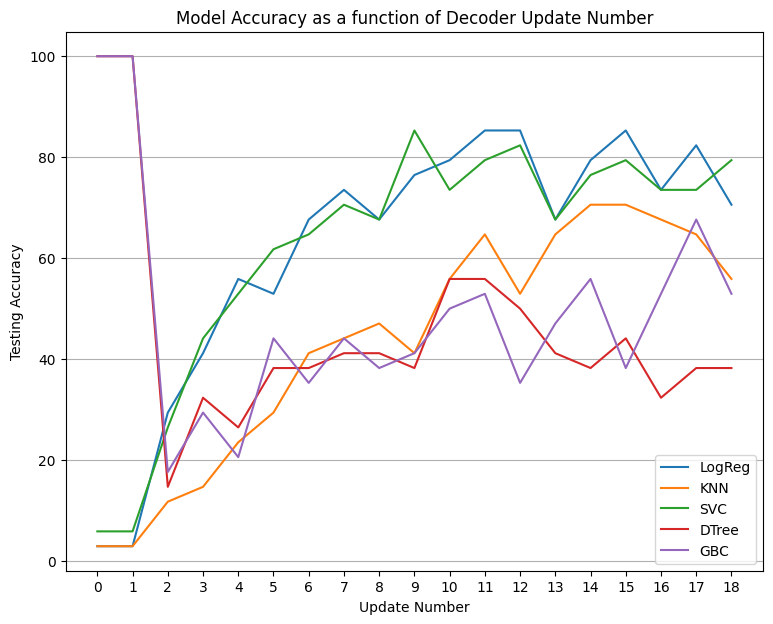

In [18]:
plt.figure(figsize=(9,7))
plt.plot(list(range(19)), lr_df.iloc[:, 2], label='LogReg')
plt.plot(list(range(19)), knn_df.iloc[:, 2], label='KNN')
plt.plot(list(range(19)), svc_df.iloc[:, 2], label='SVC')
plt.plot(list(range(19)), dt_df.iloc[:, 2], label='DTree')
plt.plot(list(range(19)), gbt_df.iloc[:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

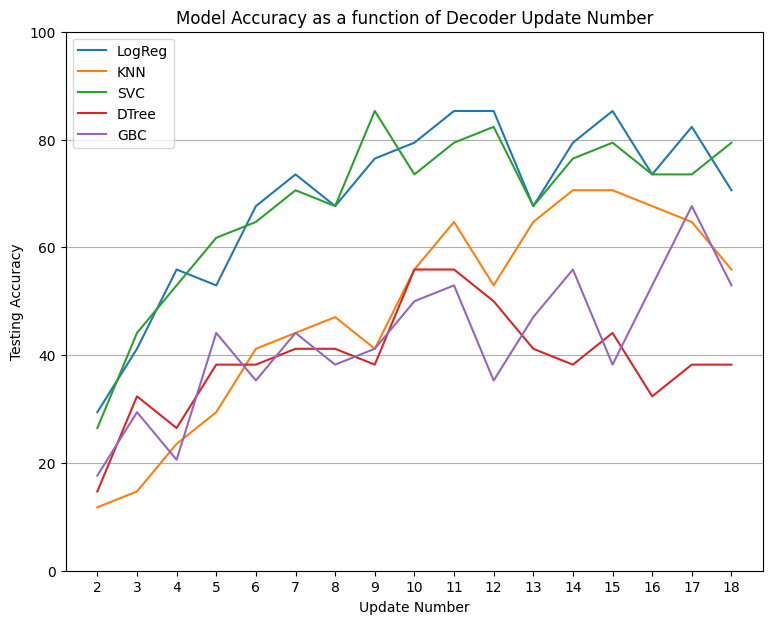

In [19]:
my_x_updates = list(range(19))[2:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[2:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[2:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[2:, 2], label='SVC')
plt.plot(my_x_updates, dt_df.iloc[2:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[2:, 2], label='GBC')
plt.xticks(np.arange(2, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

## Save Data

In [20]:
# Prevent re-saving the data
assert(1==0)

In [21]:
# Save model dfs so I don't have to rerun all this code
lr_df.to_pickle(r"Saved_Metrics\104_full_lr_df.pkl")
knn_df.to_pickle(r"Saved_Metrics\104_full_knn_df.pkl")
svc_df.to_pickle(r"Saved_Metrics\104_full_svc_df.pkl")
dt_df.to_pickle(r"Saved_Metrics\104_full_dt_df.pkl")
gbt_df.to_pickle(r"Saved_Metrics\104_full_gbt_df.pkl")